# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [171]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/Advertising.csv',index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [172]:
df.isna().sum()
#Пропущенных значений нет

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [173]:
X = np.column_stack((df['TV'], df['radio'], df['newspaper']))
y = df['sales']

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [174]:
import numpy as np
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [175]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [178]:
w = np.zeros(X.shape[1])

for i in range(1000):
    r = y - X @ w
    
    for j in range(len(w)):
        r = r + X[:, j] * w[j]
        w[j] = X[:, j] @ r
        r -= X[:, j] * w[j]        
print(w)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [177]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [232]:
X = np.column_stack((df['TV'], df['radio'], df['newspaper']))
for i in range(X.shape[1]):
    mean, std = X[:, i].mean(), X[:, i].std()
    X[:, i]=(X[:, i] - mean)/std

**Добавим единичный столбец**

In [233]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [234]:
def mse_error(y, y_pred):
    err_sum = ((y - y_pred)**2).sum()
    return err_sum / len(y_pred)

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [235]:
y_pred = np.array([y.mean()] * len(y))
print(mse_error(y, y_pred))

27.085743750000002


**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [236]:
def lin_pred(X, w):
    return X @ w

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [237]:
def stoch_grad_step(X, y, w, train_ind, eta):
    x = X[train_ind]
    y_pred = lin_pred(x, w)
    direction = x * 2.0 * (y_pred - y[train_ind]) / len(y)
    return w - direction * eta

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [260]:
def stochastic_gradient_descent(X, y, w_init, eta, max_iter, stop_dist):
    cur_dist = np.inf
    w = w_init
    errors = []
    i = 0
    
    while cur_dist > stop_dist and i < max_iter:
        train_ind = np.random.randint(len(y))
        w_new = stoch_grad_step(X, y, w, train_ind, eta)
        
        error = mse_error(y, lin_pred(X, w_new))
        errors.append(error)
        
        cur_dist = np.linalg.norm(w - w_new)
        w = w_new
        i += 1
        
    return w, errors

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

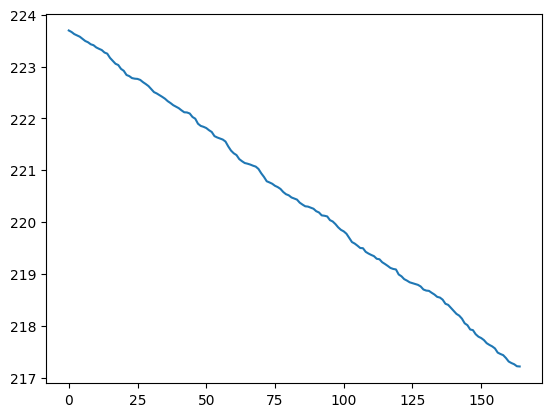

In [264]:
w, errors = stochastic_gradient_descent(X, y, np.zeros(X.shape[1]), 0.01, 10**5, 0.0004)             

import matplotlib.pyplot as plt
plt.plot(range(len(errors)), errors)

**Выведите вектор весов, к которому сошелся метод.**

In [265]:
print(w)

[ 0.23614607 -0.01694515  0.01686657 -0.01146989]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [266]:
print(errors[-1])

217.2139171227454
